# Aprendizaje Profundo para Procesamiento deSeñales de Imagen y Vídeo (APPIV)
## Master in Data Science / Máster en Ciencia de Datos
## Universidad Autonoma de Madrid

## **Tutorial: multiple object tracking**

This tutorial will show you **how to define and run a simple multi-object tracker**. This tracker is based on the tracking-by-detection scheme. Hence, the first step is an object detector which is applied to each frame independently and the second step is data association where the detections are linked to the tracks of the previous frame. 

For evaluation, you will use the [MOT16](https://motchallenge.net/data/MOT16/) dataset.  To compare tracking performance of different trackers without the effect of the object detector, the [MOTChallenge](https://motchallenge.net/data/MOT16/) provides precomputed sets of public object detections. Trackers are then evaluated on their capabilities to form tracks with the provided set. However, this tutorial uses detections computed with your own detector (`private detections`).

This tutorial can be run using cloud resources via `Google Colaboratory` or using local resources (i.e. lab computers) using Jupyter notebooks and through `Colab` (see for example this [link](https://research.google.com/colaboratory/local-runtimes.html#:~:text=In%20Colaboratory%2C%20click%20the%20%22Connect,connected%20to%20your%20local%20runtime))

Author: Juan Carlos San Miguel (juancarlos.sanmiguel@uam.es)


# 1 Setup

## 1.1 Install Python libraries

The following code will install some required packages and the utilities to compute the performance evaluation metrics `py-motmetrics` (an alternative link is available in case the official one does not work).

This tutorial has been tested in `Google Colaboratory` for the following versions:
* `Python` 3.7.X 
* `Pytorch` 1.13.0 with `torchvision` 0.14.0 and `torchaudio` 0.13.0 
* Support for `CUDA` libraries 11.6

At your own risk, feel free to employ other versions for the required packages.

In [1]:
!pip install git+https://github.com/cheind/py-motmetrics.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cheind/py-motmetrics.git to /tmp/pip-req-build-5bmilsku
  Running command git clone --filter=blob:none --quiet https://github.com/cheind/py-motmetrics.git /tmp/pip-req-build-5bmilsku
  Resolved https://github.com/cheind/py-motmetrics.git to commit beb864a56d6055047c4d6e015188fcc24aca05b7
  Preparing metadata (setup.py) ... done
  Created wheel for motmetrics: filename=motmetrics-1.4.0-py3-none-any.whl size=162181 sha256=6e3a75322d3ffc4171065b2418accfd034c0c2aecac2a5370df52cf9c4ba6ad4
  Stored in directory: /tmp/pip-ephem-wheel-cache-4u0u_56t/wheels/fa/43/80/267b90f028883ee680a5c3260e08a80a8ed9f0fc0afdf2e704
Successfully built motmetrics


In [2]:

  %load_ext autoreload
%autoreload 2
%matplotlib inline

!pip3 install tqdm lap
!pip3 install torch==1.13.0+cu116 torchvision==0.14.0+cu116 torchaudio===0.13.0+cu116 --extra-index-url https://download.pytorch.org/whl/cu116 #Pytorch and requirements
!pip3 install https://github.com/timmeinhardt/py-motmetrics/archive/fix_pandas_deprecating_warnings.zip #Evaluation metrics for MOT
!pip install git+https://github.com/cheind/py-motmetrics.git
#!pip3 install http://www-vpu.eps.uam.es/~jcs/APPIV/py-motmetrics-fix_pandas_deprecating_warnings.zip # #Evaluation metrics for MOT (alternative link)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lap: filename=lap-0.4.0-cp310-cp310-linux_x86_64.whl size=1655217 sha256=75fc69b688c4697cb60d4a51307f8b1ec321f94e68dc9126dc893debb8d36c14
  Stored in directory: /root/.cache/pip/wheels/00/42/2e/9dfe19270eea279d79e84767ff0d7b8082c3bf776cad00e83d
Successfully built lap
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 529.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 54.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu11

In [3]:
import torch, torchvision, torchaudio
print(torch.__version__)
print(torchvision.__version__)
print(torchaudio.__version__)

1.13.0+cu116
0.14.0+cu116
0.13.0+cu116


## 1.2 Connect to Google Drive
We will connect to your Google Drive account so we can save downloaded data and obtained results.

If you are not using `Google Colaboratory` (e.g. running the notebook in computer labs), you do not need to execute the following code and also, you may need changing the paths indicated by `download_dir` and `working_dir` to suitable locations adapted to your setup.

In [4]:
# Connet to Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## 1.3 Download material for the assignment 

We will download the material for the assignment in [this zip file](http://www-vpu.eps.uam.es/~jcs/APPIV/appiv_p2_material.zip) to your Google Drive account.

The `download_dir` path points to the downloads directory in your Google Drive. You need to download this file once.


In [5]:
import os, subprocess

# path to download in Google Drive
download_dir = '/content/gdrive/My Drive/downloads/' 

# file with the material for the assignment
urlfile = 'http://www-vpu.eps.uam.es/~jcs/APPIV/appiv_p2_material.zip'
datafile = os.path.basename(urlfile) #with extension

# Download material if not available in download directory
datadownload_path = os.path.join(download_dir,datafile)
if os.path.isfile(datadownload_path) == False: 
  !curl $urlfile --create-dirs -o "$datadownload_path"
  print('The file \'{}\' has been downloaded to directory \'{}\''.format(datafile,download_dir))
else:
  print('The file \'{}\' is already available in the directory \'{}\''.format(datafile,download_dir))

The file 'appiv_p2_material.zip' is already available in the directory '/content/gdrive/My Drive/downloads/'


## 1.4 Copy material to local directory 

We will copy the downloaded material to a local directory of the Virtual Machine (VM), as the processing/reading is faster than using Drive folders. The `working_dir` path points to a working directory in the Virtual Machine . 

Data (dataset and source code files) is copied from the `download_dir` directory to the `working_dir` directory.

In [6]:
import os, subprocess, zipfile
from tqdm.autonotebook import tqdm

# path to working directory (local, will be deleted when VM disconnected)
working_dir = '/content/work/'                      

# copy downloaded file to the working directory
print('Copying file \'{}\' from \'{}\' to \'{}\'...'.format(datafile,download_dir,working_dir))
if os.path.isfile(os.path.join(working_dir,datafile)) == False: 
  !rsync -ah --progress "$datadownload_path" "$working_dir"
else:
  print('already exists!')

# uncompress/unzip file in the working directory
print('\nUnzipping file \'{}\' in directory \'{}\'...'.format(datafile, working_dir), end='')
if os.path.isdir(os.path.join(working_dir,'data')) == False: 
  with zipfile.ZipFile(os.path.join(working_dir,datafile)) as zf:
    for member in tqdm(zf.infolist(), desc='Extracting '):
        try:
          zf.extract(member, working_dir)
        except zipfile.error as e:
            pass
else:
  print('already unzipped!')



Copying file 'appiv_p2_material.zip' from '/content/gdrive/My Drive/downloads/' to '/content/work/'...
sending incremental file list
created directory /content/work
appiv_p2_material.zip
          1.08G 100%   36.43MB/s    0:00:28 (xfr#1, to-chk=0/1)

Unzipping file 'appiv_p2_material.zip' in directory '/content/work/'...

Extracting :   0%|          | 0/8232 [00:00<?, ?it/s]

##1.5 Add source code location to system path

We will add the path of the source code provided in the material, so we can import and run the required functionalities for this assignment (tracker, metrics,...).

If everything has been setup correctly, the downloaded source code should be in the directory '/content/work/src/'


In [ ]:
pip install git+https://github.com/cheind/py-motmetrics.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cheind/py-motmetrics.git to /tmp/pip-req-build-qjay7qan
  Running command git clone --filter=blob:none --quiet https://github.com/cheind/py-motmetrics.git /tmp/pip-req-build-qjay7qan
  Resolved https://github.com/cheind/py-motmetrics.git to commit beb864a56d6055047c4d6e015188fcc24aca05b7
  Preparing metadata (setup.py) ... done


In [ ]:
import sys,os

# add the path to the system so we can import the tracker
sys.path.append(os.path.join(working_dir,'src/'))

# test that we can successfully import the tracker
from tracker.tracker import Tracker
print('If \'from tracker.tracker import Tracker\' shows no errors, you can import and execute the sample tracker code.\n')
print('Source files of the tracker are available at the directory \'{}\':'.format(working_dir+'src/tracker/'))
!ls $working_dir/src/tracker

print('object_detector.py --> defines the object detector to be employed for tracking (FRCNN_FPN)')
print('tracker.py         --> defines the architecture for developing trackers (i.e. common functions)')
print('data_obj_detect.py --> utility for handing datasets/sequences for object detection')
print('data_track.py      --> utility for handing datasets/sequences for object tracking')
print('utils.py           --> Utilities for evaluation and plotting')

If 'from tracker.tracker import Tracker' shows no errors, you can import and execute the sample tracker code.

Source files of the tracker are available at the directory '/content/work/src/tracker/':
data_obj_detect.py  __init__.py		__pycache__  utils.py
data_track.py	    object_detector.py	tracker.py
object_detector.py --> defines the object detector to be employed for tracking (FRCNN_FPN)
tracker.py         --> defines the architecture for developing trackers (i.e. common functions)
data_obj_detect.py --> utility for handing datasets/sequences for object detection
data_track.py      --> utility for handing datasets/sequences for object tracking
utils.py           --> Utilities for evaluation and plotting


# 2 Dataset: MOT16

The MOT16 challenge provides 7 train and 7 test video sequences with multiple objects (pedestrians) per frame. It includes many challening scenarios with camera movement, high crowdedness and object occlusions. See the [webpage](https://motchallenge.net/data/MOT16/) for video sequences with ground truth annotation. For the `train` set, ground-truth data and images are provided, so you can train and evaluate your algorithm. For the `test` set, only images are provided and ground-truth data is unknown to researchers. The evaluation is carried out using an evaluation server at the [MOT challenge site](https://motchallenge.net/instructions/). This evaluation scheme prevents cheating by doing training also on the `test` set.


##2.1 Train/test split 

For this assignment, we have splitted the original `train` set of MOT16 in two sets for `train` (4 sequences) and `test` (3 sequences). The following code shows the splitting done in the downloaded material:

In [ ]:
#list the contents of the 'train' directory
train_dir = os.path.join(working_dir,'data/MOT16/train')
print('Train directory:')
!ls $train_dir

#list the contents of the 'test' directory
test_dir = os.path.join(working_dir,'data/MOT16/test')
print('Test directory:')
!ls $test_dir

Train directory:
MOT16-02  MOT16-04  MOT16-05  MOT16-09
Test directory:
MOT16-10  MOT16-11  MOT16-13


## 2.2 Visualization 

The following code shows the ground-truth detections for each sequence in the `train` and `test` sets.

The `MOT16Sequences` dataset class provides the possibilty to load single sequences, e.g., `seq_name = 'mot16_02'`, or the entire train/test set, e.g., `seq_name = 'mot16_train'`. The associated code is defined in the file `./src/tracker/data_track.py`

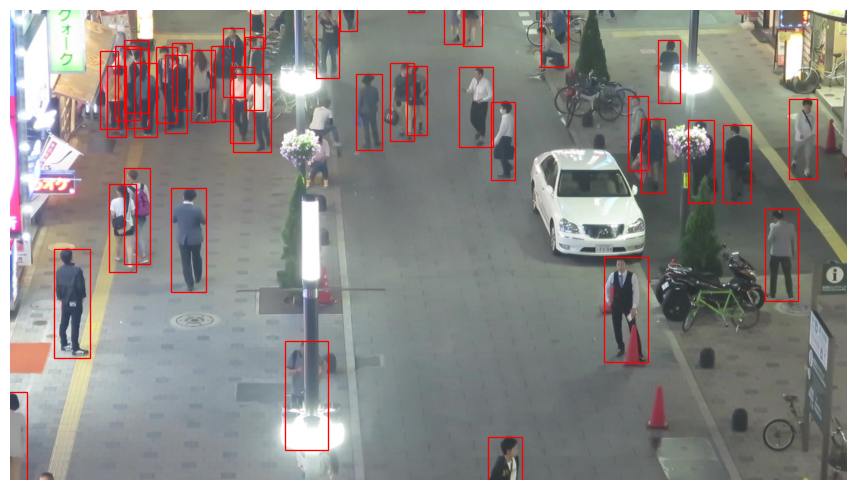

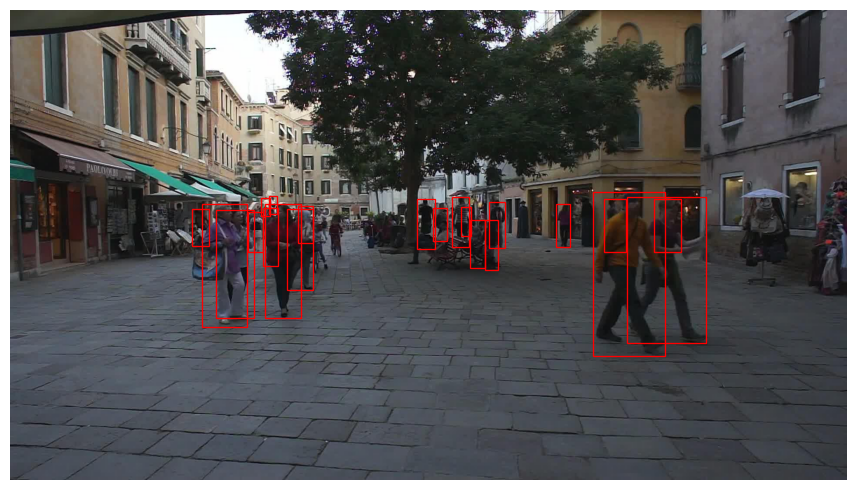

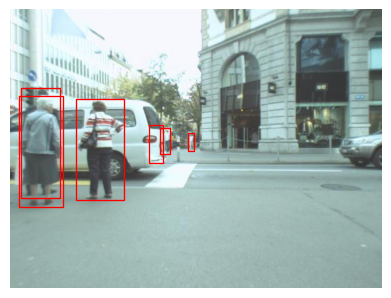

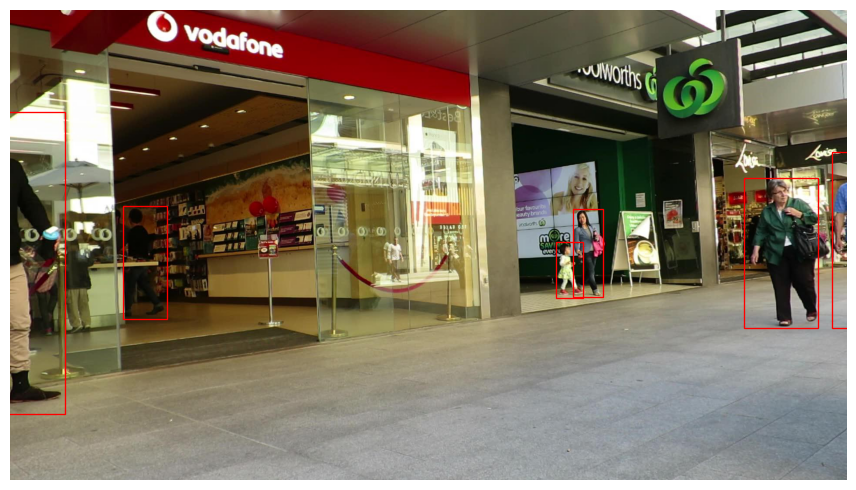

In [ ]:
import matplotlib.pyplot as plt
from tracker.data_track import MOT16Sequences

# seq_name = 'MOT16-02'
seq_name = 'MOT16-train'
# seq_name = 'MOT16-test'
data_dir = os.path.join(working_dir,'data/MOT16')
sequences = MOT16Sequences(seq_name, data_dir, load_seg=True)

for seq in sequences:
    for i, frame in enumerate(seq):
        img = frame['img']
        
        dpi = 96
        fig, ax = plt.subplots(1, dpi=dpi)

        img = img.mul(255).permute(1, 2, 0).byte().numpy()
        width, height, _ = img.shape
          
        ax.imshow(img, cmap='gray')
        fig.set_size_inches(width / dpi, height / dpi)

        if 'gt' in frame:
            gt = frame['gt']
            for gt_id, box in gt.items():
                rect = plt.Rectangle(
                  (box[0], box[1]), box[2] - box[0],box[3] - box[1],
                  fill=False,
                  edgecolor="red",
                  linewidth=1.0)
                ax.add_patch(rect)

        plt.axis('off')
        plt.show()

        break #we only plot the first image for each sequence

#3 Object detector

We provide you with an object detector pretrained on the MOT challenge training set. This detector can be used and improved to generate the framewise detections necessary for the subsequent tracking and data association step.

The object detector is a [Faster R-CNN](https://arxiv.org/abs/1506.01497) with a Resnet50 feature extractor. We trained the native PyTorch implementation of Faster-RCNN for pedestrian detection. For more information check out the corresponding PyTorch [tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

The associated code is defined in the file `./src/tracker/object_detector.py`

## 3.1 Model

The trained model is provided in the directory `model_dir`.

In [ ]:
# path for the source code of the tracker
model_dir=working_dir+'models/'

print('Model files of the tracker are available at the directory \'{}\':'.format(model_dir))
!ls "$model_dir"

Model files of the tracker are available at the directory '/content/work/models/':
faster_rcnn_fpn.model


##3.2 Configuration
The configuration of the detector is described as follows:

In [ ]:
import torch

#select GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#location of the model file
obj_detect_model_file = os.path.join(working_dir, "models/faster_rcnn_fpn.model")

#threshold for non maximum suppression
obj_detect_nms_thresh = 0.5

#detector has been trained for two classes
num_classes=2 # 1 class (person) + background (see https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

##3.3 Creation of the object detector

To create the object detector, we will use the functionality provided in the file `./src/tracker/object_detector.py`.

In [ ]:
from tracker.object_detector import FRCNN_FPN

# object detector
obj_detect = FRCNN_FPN(num_classes=num_classes, nms_thresh=obj_detect_nms_thresh)
obj_detect_state_dict = torch.load(obj_detect_model_file,map_location=lambda storage, loc: storage)
obj_detect.load_state_dict(obj_detect_state_dict)

# prints the architecture and sets the model to evaluation mode.
obj_detect.eval()

# loads detector to CPU or GPU (if available)
obj_detect.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' and 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FRCNN_FPN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu)

##3.4 Evaluate the object detector 

In addition, the trained object detector can be evaluated on the `MOT16` dataset. 
To load the  MOT16 data (images and ground-truth bounding boxes), we will use functionality provide by MOT16 dev kit (`./src/tracker/data_obj_detect.py`) and Pytorch (`Dataloader`).

To perform such evaluation, we will use functionalities provided in the file `./src/tracker/utils.py`. If you run the following code, you will get an evaluation of the object detector over the training set. Estimated execution and testing time (15-20 minutes for the train set)

In [ ]:
from torch.utils.data import DataLoader
from tracker.data_obj_detect import MOT16ObjDetect
from tracker.utils import (evaluate_obj_detect, obj_detect_transforms)

#load train set for the MOT16 data (images and ground-truth bounding boxes)
dataset_test = MOT16ObjDetect(os.path.join(working_dir, 'data/MOT16/train'), obj_detect_transforms(train=False))
def collate_fn(batch):
    return tuple(zip(*batch))
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=2,collate_fn=collate_fn)

#evaluation
evaluate_obj_detect(obj_detect, data_loader_test)

  0%|          | 0/3012 [00:00<?, ?it/s]

AP: 0.8933377876084685 Prec: 0.9091963295351416 Rec: 0.938094990376112 TP: 54099.0 FP: 5403.0


#4 Multi-object tracking

We provide a simple baseline tracker which predicts object detections for each frame and generates tracks by assigning current detections to previous detections via Intersection over Union.

Your task is to work using this baseline, trying to improve the performance (`MOTA` metric). 

## 4.1 Configuration
As configuration we need to define the object detector, the sequences to be analyzed and the output directory.

In [ ]:
import torch
from tracker.object_detector import FRCNN_FPN

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# object detector
obj_detect = FRCNN_FPN(num_classes=num_classes, nms_thresh=obj_detect_nms_thresh)
obj_detect_state_dict = torch.load(obj_detect_model_file,map_location=lambda storage, loc: storage)
obj_detect.load_state_dict(obj_detect_state_dict)
obj_detect.eval()     # set to evaluation mode
obj_detect.to(device) # load detector to GPU or CPU

# select dataset
seq_name = 'MOT16-test' #'MOT16-train', 'MOT16-02'
data_dir = os.path.join(working_dir, 'data/MOT16')
sequences = MOT16Sequences(seq_name, data_dir)
print('Loaded {:d} sequences for {:s}'.format(len(sequences),seq_name))

#output directory
output_dir = os.path.join(working_dir, 'output')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' and 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded 3 sequences for MOT16-test


Also, run the following code to allow repeatable results.

In [ ]:
print(sequences.append('MOTAA'))

AttributeError: ignored

In [ ]:
import torch
import numpy as np 

seed = 12345 #seed to allow repeatable results
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

## 4.2 Extend the baseline tracker

The class `Tracker` in file `./src/tracker/tracker.py` contains the skeleton of the baseline tracker. You modifications and improvements should be based on this class.

As a suggestion, we provide a code example to extend the functionality of the baseline tracker by overriding the `data_association` function (which is empty in the baseline tracker). This extensions generates tracks by assigning current detections to previous detections via `Intersection over Union` in a greedy way.

In [ ]:
import numpy as np
import motmetrics as mm
mm.lap.default_solver = 'lap'
from tracker.tracker import Tracker

# extended class 'Tracker' based on IoU criterion
class TrackerIoUAssignment(Tracker):

    def data_association(self, boxes, scores):
        if self.tracks:
            track_ids = [t.id for t in self.tracks]
            track_boxes = np.stack([t.box.numpy() for t in self.tracks], axis=0)
            
            # compute distance based on IoU (distance=1-IoU)
            distance = mm.distances.iou_matrix(track_boxes, boxes.numpy(), max_iou=0.5)

            # update existing tracks
            remove_track_ids = []
            for t, dist in zip(self.tracks, distance):
                if np.isnan(dist).all():
                    remove_track_ids.append(t.id)
                else:
                    match_id = np.nanargmin(dist)
                    t.box = boxes[match_id]
            self.tracks = [t for t in self.tracks
                           if t.id not in remove_track_ids]

            # add new tracks
            new_boxes = []
            new_scores = []
            for i, dist in enumerate(np.transpose(distance)):
                if np.isnan(dist).all():
                    new_boxes.append(boxes[i])
                    new_scores.append(scores[i])
            self.add(new_boxes, new_scores)

        else:
            self.add(boxes, scores)
        
# create a new tracker using the 'TrackerIoUAssignment' class
tracker = TrackerIoUAssignment(obj_detect)
print('Tracker created!')

Tracker created!


## 4.3 Run tracker
The following code runs the tracker created previously for the selected test sequences. It also prints some statistics for each sequence.

The estimated running time for the `train`/`test` sets is 10-15 minutes.

In [ ]:
import time
from tqdm.autonotebook import tqdm
from tracker.utils import get_mot_accum

time_total = 0
mot_accums = []
results_seq = {}

for seq in sequences:
    print(f"Tracking: {seq}")
    now = time.time()

    # restart tracker state for each sequence
    tracker.reset()
    
    #load data
    data_loader = DataLoader(seq, batch_size=1, shuffle=False)

    #run tracker
    for frame in tqdm(data_loader):
        tracker.step(frame)

    #keep results
    results = tracker.get_results()
    results_seq[str(seq)] = results

    #perform evaluation
    if seq.no_gt:
        print(f"No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq)) #compute and store eval metrics 

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    #save results to output directory
    seq.write_results(results, os.path.join(output_dir))

Tracking: MOT16-13


  0%|          | 0/750 [00:00<?, ?it/s]

Se han truncado las últimas 5000 líneas del flujo de salida.
        nan        nan        nan        nan        nan        nan
        nan        nan 0.46020555        nan        nan        nan
        nan]
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.33438562]
[       nan        nan        nan 0.47652543        nan        nan
 0.12722889        nan        nan        nan 0.21632922        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan]
[       nan        nan        nan        nan        nan        nan
        nan 0.06917654        nan        nan        nan        nan
 0.36425322        nan        nan        nan        nan        nan
        nan        nan       

  0%|          | 0/900 [00:00<?, ?it/s]

Se han truncado las últimas 5000 líneas del flujo de salida.
        nan        nan        nan]
[       nan        nan        nan        nan        nan        nan
        nan        nan 0.02816092]
[       nan 0.49301586 0.01955821        nan 0.40808819        nan
        nan        nan        nan]
[       nan        nan 0.01563301        nan        nan 0.46768398
        nan        nan        nan        nan]
[       nan        nan        nan        nan 0.00943002 0.39714387
 0.4414424  0.35528377 0.38894554        nan]
[0.02330379        nan        nan        nan        nan        nan
        nan        nan        nan        nan]
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.04414115]
[       nan 0.01422162        nan 0.39552975        nan        nan
        nan        nan        nan        nan]
[       nan        nan 0.01094365 0.4796389         nan        nan
        nan        nan        nan]
[       nan        nan        nan

  0%|          | 0/654 [00:00<?, ?it/s]

Se han truncado las últimas 5000 líneas del flujo de salida.
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan]
[       nan        nan        nan        nan        nan        nan
        nan 0.03553502        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan]
[0.01351406 0.25700046        nan        nan 0.49040017        nan
        nan 0.46904328        nan        nan        nan        nan
        nan        nan 0.45255381        nan        nan        nan
        nan        nan        nan 0.48452107        nan        nan
 0.49444266]
[0.01351406 0.25700046        nan        nan 0.49040017        nan
        nan 0.46904328        nan        nan        nan        nan
        nan        nan 0.4525

## 4.4 Evaluate tracking results

The following code computes the performance evaluation metrics for the generated tracking results. You can check the definitions of the evaluation metrics at this [paper](https://arxiv.org/abs/1603.00831).

In [ ]:
from tracker.utils import evaluate_mot_accums

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(mot_accums,
                        [str(s) for s in sequences if not s.no_gt],
                        generate_overall=True)

Runtime for all sequences: 666.2 s.
          IDF1   IDP   IDR  Rcll  Prcn  GT MT PT  ML    FP    FN IDs   FM  MOTA  MOTP IDt IDa IDm
MOT16-13 41.7% 50.9% 35.3% 43.1% 62.1% 110 28 34  48  3065  6620 105  161 15.9% 0.132  75  69  39
MOT16-11 48.9% 52.9% 45.4% 55.9% 65.1%  75 17 28  30  2832  4162  18   36 25.7% 0.078  23  15  20
MOT16-10 32.3% 34.8% 30.2% 41.6% 48.0%  57 12 23  22  5792  7501  79  143 -4.2% 0.139  45  45  11
OVERALL  40.1% 44.9% 36.2% 46.1% 57.2% 242 57 85 100 11689 18283 202  340 11.0% 0.116 143 129  70


As a reference, the current state-of-the-art multi-object tracker [Tracktor++](https://arxiv.org/abs/1903.05625) achieves the following tracking results on the full `MOT16-train` sequences:

              IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT  ML  FP    FN IDs   FM  MOTA  MOTP
    MOT16-02 45.8% 78.3% 32.4% 41.3% 99.8%  62   9  32  21  18 10909  59   68 40.9% 0.080
    MOT16-04 71.1% 90.3% 58.6% 64.7% 99.8%  83  32  29  22  71 16785  22   29 64.5% 0.096
    MOT16-05 64.0% 86.6% 50.7% 57.5% 98.1% 133  32  65  36  75  2942  37   59 55.8% 0.144
    MOT16-09 54.6% 69.4% 45.0% 64.3% 99.1%  26  11  13   2  31  1903  22   31 63.3% 0.086
    MOT16-10 64.3% 75.7% 55.9% 72.4% 98.0%  57  28  26   3 189  3543  71  125 70.4% 0.148
    MOT16-11 63.3% 77.0% 53.7% 69.0% 98.9%  75  24  33  18  73  2924  26   26 68.0% 0.081
    MOT16-13 73.6% 85.1% 64.8% 74.2% 97.6% 110  60  39  11 213  3000  62   90 71.9% 0.132
    OVERALL  65.0% 84.0% 53.1% 62.6% 99.1% 546 196 237 113 670 42006 299  428 61.7% 0.106

Note that the `MOT16-train` set is different from the sets of this assignment:  `train` (first four sequences of `MOT16-train`) and `test` (last three sequences of `MOT16-train`). 

For your final submission you should focus on improving `MOTA` for the `train` and `test` sets provided as material of this assignment.

## 4.5 Visualize tracking results

The following code shows some sample results for a particular sequence.

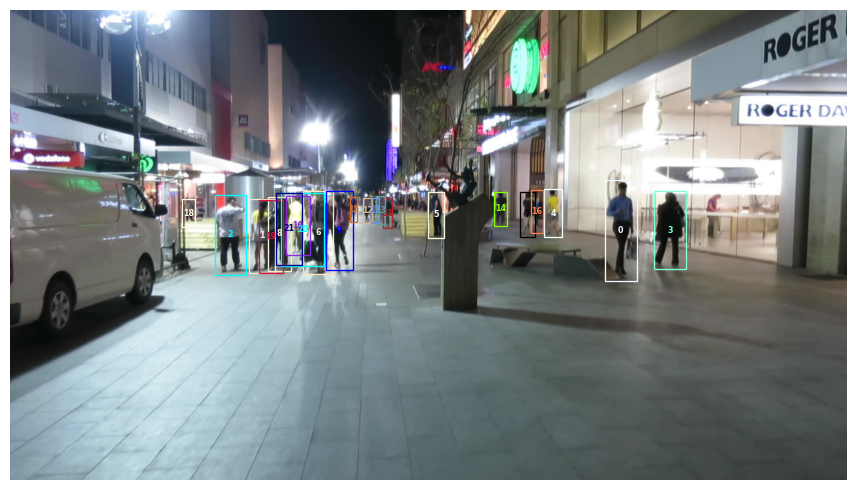

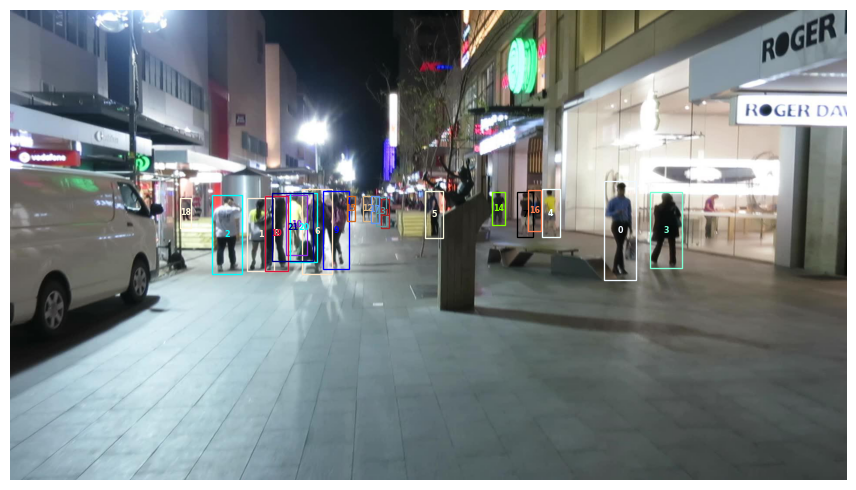

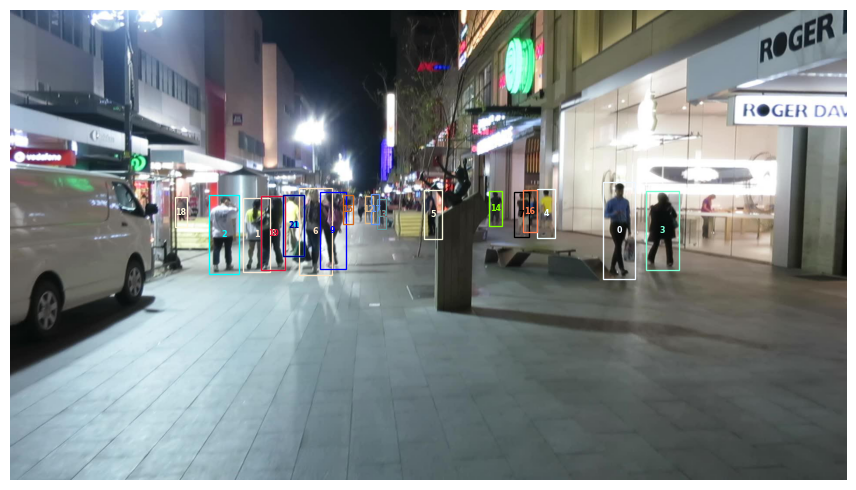

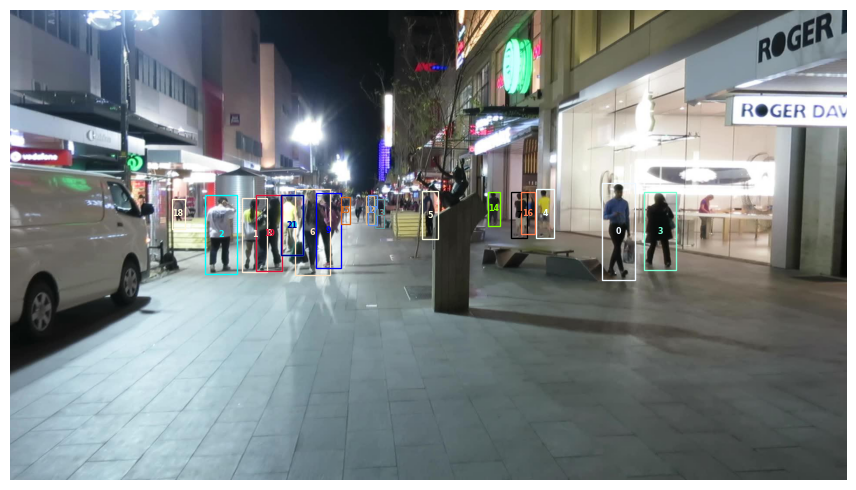

In [ ]:
import matplotlib.pyplot as plt
from tracker.utils import plot_sequence

plot_sequence(results_seq['MOT16-10'],
              [s for s in sequences if str(s) == 'MOT16-10'][0],
              first_n_frames=3)

## 4.6 Copy results to Google Drive
The `seq.write_results(results, os.path.join(output_dir))` statement saves predicted tracks into files. After executing this cell the `output` directory in your Google Drive should contain multiple `MOT16-XY.txt` files.

Here we will copy these results in the `download_dir` directory of your Google Drive account.

In [ ]:
#copy output files to download directory in personal Google Drive
!cp -r $output_dir "$download_dir"

#show output files
print('Output tracking results:')
path = os.path.join(download_dir,"output")
!ls "$path"


Output tracking results:
MOT16-10.txt  MOT16-11.txt  MOT16-13.txt


**Remember you will have to submit these files for both the `train` and `test` sets (in addition to the code for running your tracker).**